In [1]:
import os
# os.environ["KERAS_BACKEND"] = "jax"

import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import tensorflow as tf
# import jax
import keras

from sklearn import metrics

from tqdm.notebook import tqdm

print(tf.__version__)
# print(jax.__version__)

2.16.1


In [2]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? True


In [3]:
SEED = 42
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
DATA = "/kaggle/input/leap-atmospheric-physics-ai-climsim"
DATA_NPY = "data"

In [6]:
sample = pl.read_csv('sample_submission.csv', n_rows=1)

In [7]:
sample = pl.read_csv('leap-atmospheric-physics-ai-climsim/train.csv', n_rows=1)
TARGETS = ['ptend_t_59',
 'ptend_q0001_0',
 'ptend_q0001_1',
 'ptend_q0001_2',
 'ptend_q0001_3',
 'ptend_q0001_4',
 'ptend_q0001_5',
 'ptend_q0001_6',
 'ptend_q0001_7',
 'ptend_q0001_8',
 'ptend_q0001_9',
 'ptend_q0001_10',
 'ptend_q0001_11',
 'ptend_q0001_12',
 'ptend_q0001_13',
 'ptend_q0001_14',
 'ptend_q0001_59',
 'ptend_q0002_0',
 'ptend_q0002_1',
 'ptend_q0002_2',
 'ptend_q0002_3',
 'ptend_q0002_4',
 'ptend_q0002_5',
 'ptend_q0002_6',
 'ptend_q0002_7',
 'ptend_q0002_8',
 'ptend_q0002_9',
 'ptend_q0002_10',
 'ptend_q0002_11',
 'ptend_q0002_59',
 'ptend_q0003_0',
 'ptend_q0003_1',
 'ptend_q0003_2',
 'ptend_q0003_3',
 'ptend_q0003_4',
 'ptend_q0003_5',
 'ptend_q0003_6',
 'ptend_q0003_7',
 'ptend_q0003_8',
 'ptend_q0003_9',
 'ptend_q0003_10',
 'ptend_q0003_11',
 'ptend_q0003_12',
 'ptend_q0003_13',
 'ptend_q0003_14',
 'ptend_q0003_59',
 'ptend_u_0',
 'ptend_u_1',
 'ptend_u_2',
 'ptend_u_3',
 'ptend_u_4',
 'ptend_u_5',
 'ptend_u_6',
 'ptend_u_7',
 'ptend_u_8',
 'ptend_u_9',
 'ptend_u_10',
 'ptend_u_59',
 'ptend_v_0',
 'ptend_v_1',
 'ptend_v_2',
 'ptend_v_3',
 'ptend_v_4',
 'ptend_v_5',
 'ptend_v_6',
 'ptend_v_7',
 'ptend_v_8',
 'ptend_v_9',
 'ptend_v_10']

all_columns = sample.columns 

# Find indices of TARGETS within all_columns
target_indices = [all_columns.index(target) for target in TARGETS]

print(len(target_indices))

69


In [8]:
BATCH_SIZE = 4096
train_files = [os.path.join(DATA_NPY, "split_%d.npy" % i) for i in range(1,100)]
valid_files = [os.path.join(DATA_NPY, "split_%d.npy" % i) for i in range(100, 102)]
train_options = tf.data.Options()
train_options.deterministic = True

def create_generator(file_paths):
    for file_path in file_paths:
        data = np.load(file_path, allow_pickle=True)
        for sample in data:
            yield sample[:-368], sample[target_indices]

def create_dataset_from_npy(file_paths, batch_size=BATCH_SIZE, shuffle_buffer_size=10000, is_training=True):
    dataset = tf.data.Dataset.from_generator(
        lambda: create_generator(file_paths),
        output_signature=(tf.TensorSpec(shape=(556,), dtype=tf.float64), 
                          tf.TensorSpec(shape=(69,), dtype=tf.float64))
    )
    
    if is_training:
        dataset = dataset.shuffle(shuffle_buffer_size)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

# Create train dataset
ds_train = create_dataset_from_npy(train_files, BATCH_SIZE, is_training=True)

# Create validation dataset
ds_valid = create_dataset_from_npy(valid_files, BATCH_SIZE, is_training=False)

In [9]:
norm_x = keras.layers.Normalization()
norm_x.adapt(ds_train.map(lambda x, y: x).take(1000))

2024-06-14 09:23:53.751985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
norm_y = keras.layers.Normalization()
norm_y.adapt(ds_train.map(lambda x, y: y).take(1000))

mean_y = norm_y.mean
stdd_y =keras.ops.maximum(1e-10, norm_y.variance ** 0.5)

2024-06-14 09:28:06.057433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
mean_y = tf.cast(mean_y, tf.float64)
stdd_y = tf.cast(stdd_y, tf.float64)

In [12]:
min_y = np.min(np.stack([np.min(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)
max_y = np.max(np.stack([np.max(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)

2024-06-14 09:32:11.427142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-14 09:36:12.209875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
min_y = tf.cast(min_y, tf.float64)
max_y = tf.cast(max_y, tf.float64)

### Model definition & Training

In [24]:
@keras.saving.register_keras_serializable(package="MyMetrics", name="ClippedR2Score")
class ClippedR2Score(keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_metric = keras.metrics.R2Score(class_aggregation=None)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.base_metric.update_state(y_true, y_pred, sample_weight=None)
        
    def result(self):
        return keras.ops.mean(keras.ops.clip(self.base_metric.result(), 0.0, 1.0))
        
    def reset_states(self):
        self.base_metric.reset_states()

In [25]:
epochs = 12
learning_rate = 1e-3

epochs_warmup = 1
epochs_ending = 2
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))

lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    1e-4,
    (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
    warmup_target=learning_rate,
    warmup_steps=steps_per_epoch * epochs_warmup,
    alpha=0.1
)

In [26]:
keras.utils.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(556,)),
    tf.keras.layers.Dense(556, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dense(128, activation='relu'),  
    tf.keras.layers.Dense(69, activation='linear')
])

model.compile(
    loss='mse', 
    optimizer=keras.optimizers.Adam(learning_rate),
    metrics=[ClippedR2Score()]
)
model.build(tuple(ds_train.element_spec[0].shape))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 556)            │       309,692 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       142,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 69)             │         8,901 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 494,081 (1.88 MB)

 Trainable params: 494,081 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# model_path = '/kaggle/input/leapseq2seq/model.keras'
# model = tf.keras.models.load_model(model_path)

In [28]:
ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))

history = model.fit(
    ds_train_target_normalized,
    validation_data=ds_valid_target_normalized,
    epochs=epochs,
    verbose=1 if is_interactive() else 2,
    callbacks=[
        keras.callbacks.ModelCheckpoint(filepath='models/model64weak.keras'),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1, monitor='val_r2_score', mode='max', min_lr=1e-6),
        keras.callbacks.EarlyStopping(patience=5, verbose=1, monitor='val_r2_score', mode='max'),
    ]
)

Epoch 1/12


   2440/Unknown 640s 262ms/step - loss: 23534.1836 - r2_score: 0.0012

2024-06-14 11:22:59.935428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:22:59.935449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Size/_44]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 647s 264ms/step - loss: 23525.8242 - r2_score: 0.0012 - val_loss: 0.0019 - val_r2_score: 0.0145 - learning_rate: 0.0010
Epoch 2/12


2024-06-14 11:23:06.001264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:23:06.001279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.0054 - r2_score: 0.0012

2024-06-14 11:33:58.283030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:33:58.283054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/mse/sub/Shape/_46]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 658s 270ms/step - loss: 0.0054 - r2_score: 0.0012 - val_loss: 0.0018 - val_r2_score: 0.0145 - learning_rate: 0.0010
Epoch 3/12


2024-06-14 11:34:04.411678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IsInf/_18]]
2024-06-14 11:34:04.411692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.0054 - r2_score: 0.0011

2024-06-14 11:44:51.417117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:51.417135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/mse/sub/Shape/_46]]



Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 653s 267ms/step - loss: 0.0054 - r2_score: 0.0011 - val_loss: 0.0018 - val_r2_score: 0.0145 - learning_rate: 0.0010
Epoch 4/12


2024-06-14 11:44:57.375997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:57.376023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_4]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.0053 - r2_score: 0.0011

2024-06-14 11:55:46.804861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:55:46.804881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Size/_44]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 655s 268ms/step - loss: 0.0053 - r2_score: 0.0011 - val_loss: 0.0018 - val_r2_score: 0.0145 - learning_rate: 5.0000e-04
Epoch 5/12


2024-06-14 11:55:52.623056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:55:52.623076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IsInf/_18]]


2437/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.0053 - r2_score: 0.0011

2024-06-14 12:06:29.042149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 12:06:29.042163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_8/_34]]



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 642s 263ms/step - loss: 0.0053 - r2_score: 0.0011 - val_loss: 0.0018 - val_r2_score: 0.0145 - learning_rate: 5.0000e-04
Epoch 6/12


2024-06-14 12:06:34.846564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 12:06:34.846584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Cast/_2]]


2437/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.0053 - r2_score: 0.0011

2024-06-14 12:17:19.296664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 12:17:19.296685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/ReadVariableOp_2/_11]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 650s 266ms/step - loss: 0.0053 - r2_score: 0.0011 - val_loss: 0.0018 - val_r2_score: 0.0435 - learning_rate: 2.5000e-04
Epoch 7/12


2024-06-14 12:17:25.020606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 12:17:25.020627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_4]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.0053 - r2_score: 0.0301

2024-06-14 12:28:07.320094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 12:28:07.320131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_16/_20]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 648s 265ms/step - loss: 0.0053 - r2_score: 0.0301 - val_loss: 0.0018 - val_r2_score: 0.5072 - learning_rate: 2.5000e-04
Epoch 8/12


2024-06-14 12:28:13.220305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IsInf/_18]]
2024-06-14 12:28:13.220326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.0053 - r2_score: 0.4939

2024-06-14 12:39:01.915707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 12:39:01.915723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/mse/sub/Shape/_46]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 655s 268ms/step - loss: 0.0053 - r2_score: 0.4939 - val_loss: 0.0018 - val_r2_score: 0.8406 - learning_rate: 2.5000e-04
Epoch 9/12


2024-06-14 12:39:07.756615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 12:39:07.756630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.0053 - r2_score: 0.8272

2024-06-14 12:49:54.875142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 12:49:54.875158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_16/_20]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 653s 267ms/step - loss: 0.0053 - r2_score: 0.8272 - val_loss: 0.0018 - val_r2_score: 0.8406 - learning_rate: 2.5000e-04
Epoch 10/12


2024-06-14 12:50:00.895230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 12:50:00.895251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_4]]


2437/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.0053 - r2_score: 0.8273

2024-06-14 13:00:48.458934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:00:48.458955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/mse/sub/Shape/_46]]



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 653s 268ms/step - loss: 0.0053 - r2_score: 0.8273 - val_loss: 0.0018 - val_r2_score: 0.8406 - learning_rate: 2.5000e-04
Epoch 11/12


2024-06-14 13:00:54.302581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:00:54.302602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IsInf/_18]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.0053 - r2_score: 0.8272

2024-06-14 13:11:43.007038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:11:43.007049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_16/_20]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 655s 268ms/step - loss: 0.0053 - r2_score: 0.8272 - val_loss: 0.0018 - val_r2_score: 0.8406 - learning_rate: 1.2500e-04
Epoch 12/12


2024-06-14 13:11:49.105995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:11:49.106016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_4]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.0053 - r2_score: 0.8273

2024-06-14 13:22:38.629198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:22:38.629219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_16/_20]]



Epoch 12: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 655s 268ms/step - loss: 0.0053 - r2_score: 0.8273 - val_loss: 0.0018 - val_r2_score: 0.8406 - learning_rate: 1.2500e-04


2024-06-14 13:22:44.501643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:22:44.501661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_4]]


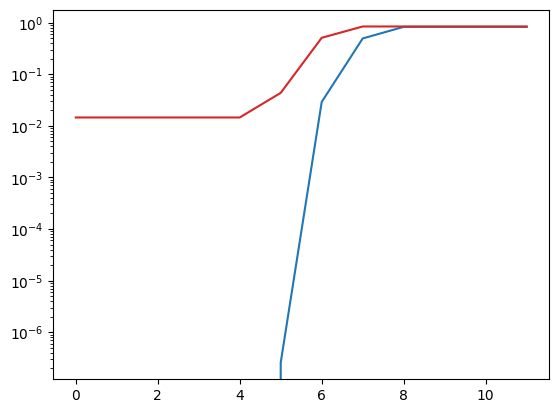

In [30]:
plt.plot(history.history['r2_score'], color='tab:blue')
plt.plot(history.history['val_r2_score'], color='tab:red')
plt.yscale('log');

In [19]:
y_valid = np.concatenate([yb for _, yb in ds_valid])
p_valid = model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

2024-06-14 05:38:23.216332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step


2024-06-14 05:38:29.596372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
p_valid.numpy()[0]

array([ 4.43602936e-05,  1.46943131e-05,  4.88305225e-05,  1.12017648e-04,
        1.02139534e-04,  1.48476938e-04,  1.28295531e-04,  1.09980766e-04,
        6.77336526e-05,  5.09136354e-05,  3.77822329e-05,  3.01005503e-05,
        2.32349838e-05,  1.87771170e-05,  1.29645279e-05,  8.63948773e-06,
        4.81879008e-06,  4.79732978e-06, -2.27718003e-06,  2.51503931e-06,
        1.88472637e-06, -1.27684880e-07,  7.28742310e-07,  5.10689741e-06,
        1.29047397e-05,  1.98162238e-05,  1.52304567e-05, -2.02140169e-06,
        7.45725039e-07,  1.93714738e-07, -3.44355754e-06, -6.67604195e-06,
       -5.15772525e-06, -7.03475992e-06, -1.20278543e-05,  6.09540875e-05,
        9.70713539e-05,  8.30128282e-05,  8.20163398e-05,  7.85220932e-05,
        1.70557049e-05,  3.06791883e-06, -1.79679316e-05, -2.53861159e-05,
       -3.68971560e-05, -4.43181952e-05, -4.01860572e-05, -2.39570120e-05,
       -1.27799796e-05, -1.67825108e-05, -2.68579965e-05, -2.78997596e-05,
       -3.31217081e-05, -

In [20]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
plt.plot(scores_valid.clip(-1, 1))

ValueError: Input arrays use different devices: cpu, /job:localhost/replica:0/task:0/device:CPU:0

In [ ]:
mask = scores_valid <= 1e-3
f"Number of under-performing targets: {sum(mask)}"

In [ ]:
f"Clipped score: {scores_valid.clip(0, 1).mean()}"

In [ ]:
del y_valid, p_valid
gc.collect();